In [1]:
import argparse
import time
import numpy as np
import scipy.sparse as sp
import torch
from torch import optim
from model import GCNModelAE, Regularizer
from optimizer import loss_function1
from utils import load_data, mask_test_edges, preprocess_graph, get_roc_score,load_data_with_labels
import matplotlib.pyplot as plt

# Hyper-parameter Setting
Here we present the same setting in our paper WARGA

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--seed', type=int, default=0, help='Random seed.')
parser.add_argument('--epochs', type=int, default=200, help='Number of epochs to train.')
parser.add_argument('--hidden1', type=int, default=32, help='Number of units in the first encoding layer.')
parser.add_argument('--hidden2', type=int, default=16, help='Number of units in the second embedding layer.')
parser.add_argument('--hidden3', type=int, default=16, help='Number of units in the first hidden layer of Regularizer.')
parser.add_argument('--hidden4', type=int, default=64, help='Number of units in the second hidden layer of Regularizer.')
parser.add_argument('--clamp', type=float, default=0.01, help='Weight clamp for Regularizer Parameters.')
parser.add_argument('--lr', type=float, default=0.001, help='Initial learning rate for Generator.')
parser.add_argument('--reglr', type=float, default=0.001, help='Initial learning rate for Regularizer.')
parser.add_argument('--dropout', type=float, default=0., help='Dropout rate (1 - keep probability).')
parser.add_argument('--dataset-str', type=str, default='cora', help='type of dataset.')

args,unknown = parser.parse_known_args()

torch.manual_seed(args.seed)
np.random.seed(args.seed)    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Model

In [4]:
def gae_for(args):
    print("Using {} dataset".format(args.dataset_str))
    adj, features,true_labels = load_data_with_labels(args.dataset_str)
    n_nodes, feat_dim = features.shape
    features = features.to(device)
    
    # Store original adjacency matrix (without diagonal entries) for later
    adj_orig = adj
    adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
    adj_orig.eliminate_zeros()
    
    # train-validation-test split
    adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = mask_test_edges(adj)
    adj = adj_train
    
    # Some preprocessing
    adj_norm = preprocess_graph(adj)
    adj_norm = adj_norm.to(device)
    
    adj_label = adj_train + sp.eye(adj_train.shape[0])
    adj_label = torch.FloatTensor(adj_label.toarray())
    adj_label = adj_label.to(device)

    pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
    norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)
    
    # Models
    model = GCNModelAE(feat_dim, args.hidden1, args.hidden2, args.dropout).to(device)
    regularizer = Regularizer(args.hidden3, args.hidden2, args.hidden4).to(device)
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    regularizer_optimizer = optim.Adam(regularizer.parameters(), lr=args.reglr)

    val_ap = []
    train_loss = []
    for epoch in range(args.epochs):
        t = time.time()
        model.train()
        regularizer.train()
        
        # Generate the embeddings
        predicted_labels_prob, emb = model(features, adj_norm)
        
        # Wasserstein Regularizer
        for i in range(1):
            f_z = regularizer(emb).to(device)
            r = torch.normal(0.0, 1.0, [n_nodes, args.hidden2]).to(device)
            f_r = regularizer(r)          
            reg_loss = - f_r.mean() + f_z.mean() 
            
            regularizer_optimizer.zero_grad()
            reg_loss.backward(retain_graph=True)
            regularizer_optimizer.step()
            
            # weight clamp
            for p in regularizer.parameters():
                p.data.clamp_(-args.clamp, args.clamp)

        # Update the Generator
        f_z = regularizer(emb)  
        generator_loss = -f_z.mean()       
        loss = loss_function1(preds=predicted_labels_prob, labels=adj_label,
                             norm=norm, pos_weight=torch.tensor(pos_weight))
        loss = loss + generator_loss
        optimizer.zero_grad()
        loss.backward()
        cur_loss = loss.item()
        optimizer.step()
        
        # Print Validation results every 10 epochs
        if epoch%40 == 0:
            hidden_emb = emb.cpu().data.numpy()
            roc_curr, ap_curr = get_roc_score(hidden_emb, adj_orig, val_edges, val_edges_false)
            print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(cur_loss))
            print("val_ap=", "{:.5f}".format(ap_curr))  
            print("time=", "{:.5f}".format(time.time() - t))
            val_ap.append(ap_curr)
            train_loss.append(cur_loss)
        
    print("Optimization Finished!")
    
    # Plot the learning curve
    fig = plt.figure(figsize=(30,10))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)

    ax1.plot(train_loss, label='Training loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend(frameon=False)

    ax2.plot(val_ap, label='Validation Average Precision Score',color='Red')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('AP')
    ax2.legend(frameon=False)

    plt.show()
    
    # Testing results
    hidden_emb = emb.cpu().data.numpy()
    roc_score, ap_score = get_roc_score(hidden_emb, adj_orig, test_edges, test_edges_false)
    print("The Last Epoch's Results are:")
    print('Test ROC score: ' + str(roc_score))
    print('Test AP score: ' + str(ap_score))
    
    return roc_score, ap_score

# Run

Seed 0
Using cora dataset
Epoch: 0001 train_loss= 0.78678
val_ap= 0.70048
time= 0.48669
Epoch: 0041 train_loss= 0.58776
val_ap= 0.82779
time= 0.05885
Epoch: 0081 train_loss= 0.51162
val_ap= 0.89428
time= 0.04687
Epoch: 0121 train_loss= 0.49222
val_ap= 0.91355
time= 0.04887
Epoch: 0161 train_loss= 0.48364
val_ap= 0.91885
time= 0.05984
Optimization Finished!


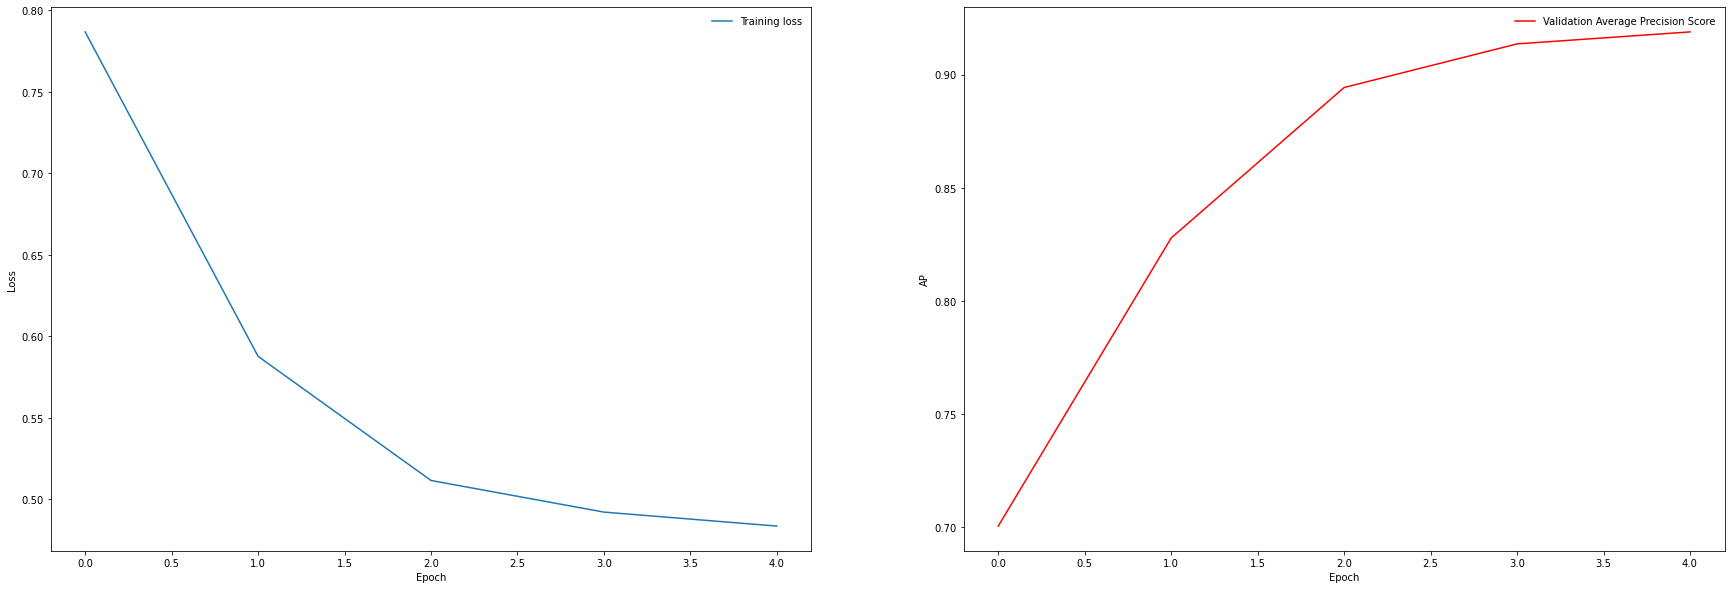

The Last Epoch's Results are:
Test ROC score: 0.929578834043258
Test AP score: 0.9373495496285346
Seed 1
Using cora dataset
Epoch: 0001 train_loss= 0.78310
val_ap= 0.71704
time= 0.05386
Epoch: 0041 train_loss= 0.54086
val_ap= 0.88296
time= 0.04787
Epoch: 0081 train_loss= 0.47599
val_ap= 0.91818
time= 0.05086
Epoch: 0121 train_loss= 0.45933
val_ap= 0.92783
time= 0.04687
Epoch: 0161 train_loss= 0.44859
val_ap= 0.92999
time= 0.05487
Optimization Finished!


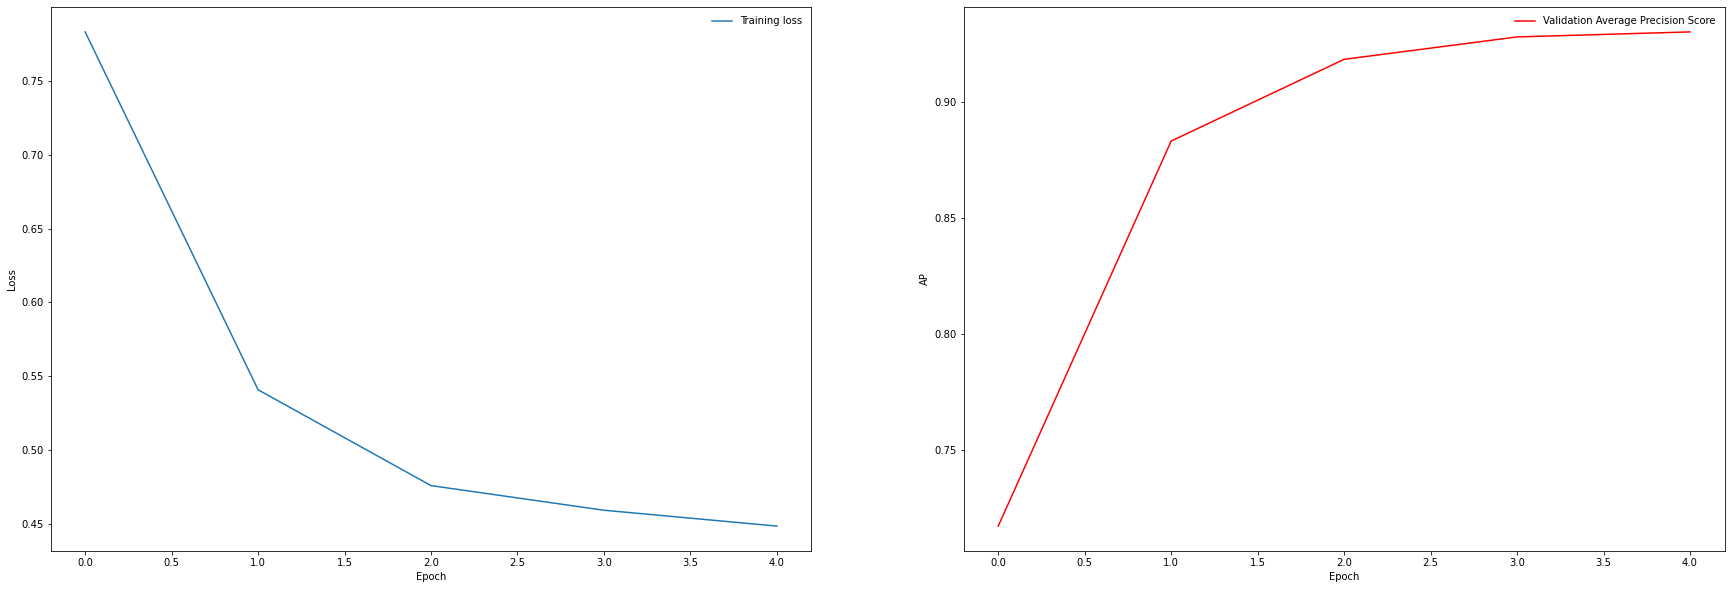

The Last Epoch's Results are:
Test ROC score: 0.9310730964357341
Test AP score: 0.9394075000573161
Seed 2
Using cora dataset
Epoch: 0001 train_loss= 0.78826
val_ap= 0.73191
time= 0.06582
Epoch: 0041 train_loss= 0.53537
val_ap= 0.85560
time= 0.05585
Epoch: 0081 train_loss= 0.45493
val_ap= 0.91420
time= 0.06980
Epoch: 0121 train_loss= 0.43796
val_ap= 0.92619
time= 0.06483
Epoch: 0161 train_loss= 0.43061
val_ap= 0.92932
time= 0.05486
Optimization Finished!


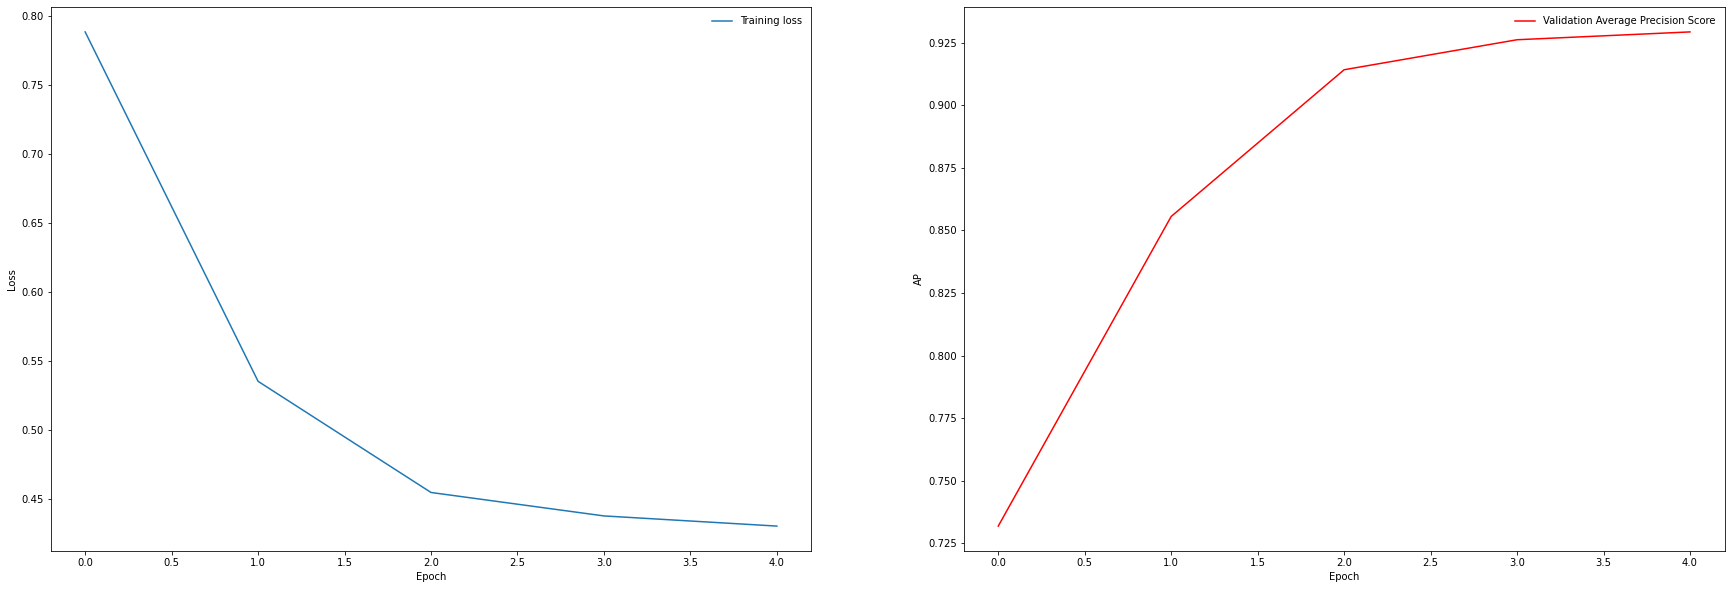

The Last Epoch's Results are:
Test ROC score: 0.9331794663142847
Test AP score: 0.939186615836546
Seed 3
Using cora dataset
Epoch: 0001 train_loss= 0.78052
val_ap= 0.71148
time= 0.04787
Epoch: 0041 train_loss= 0.54636
val_ap= 0.86627
time= 0.05585
Epoch: 0081 train_loss= 0.47938
val_ap= 0.91578
time= 0.05685
Epoch: 0121 train_loss= 0.45781
val_ap= 0.92771
time= 0.05286
Epoch: 0161 train_loss= 0.44811
val_ap= 0.93024
time= 0.05485
Optimization Finished!


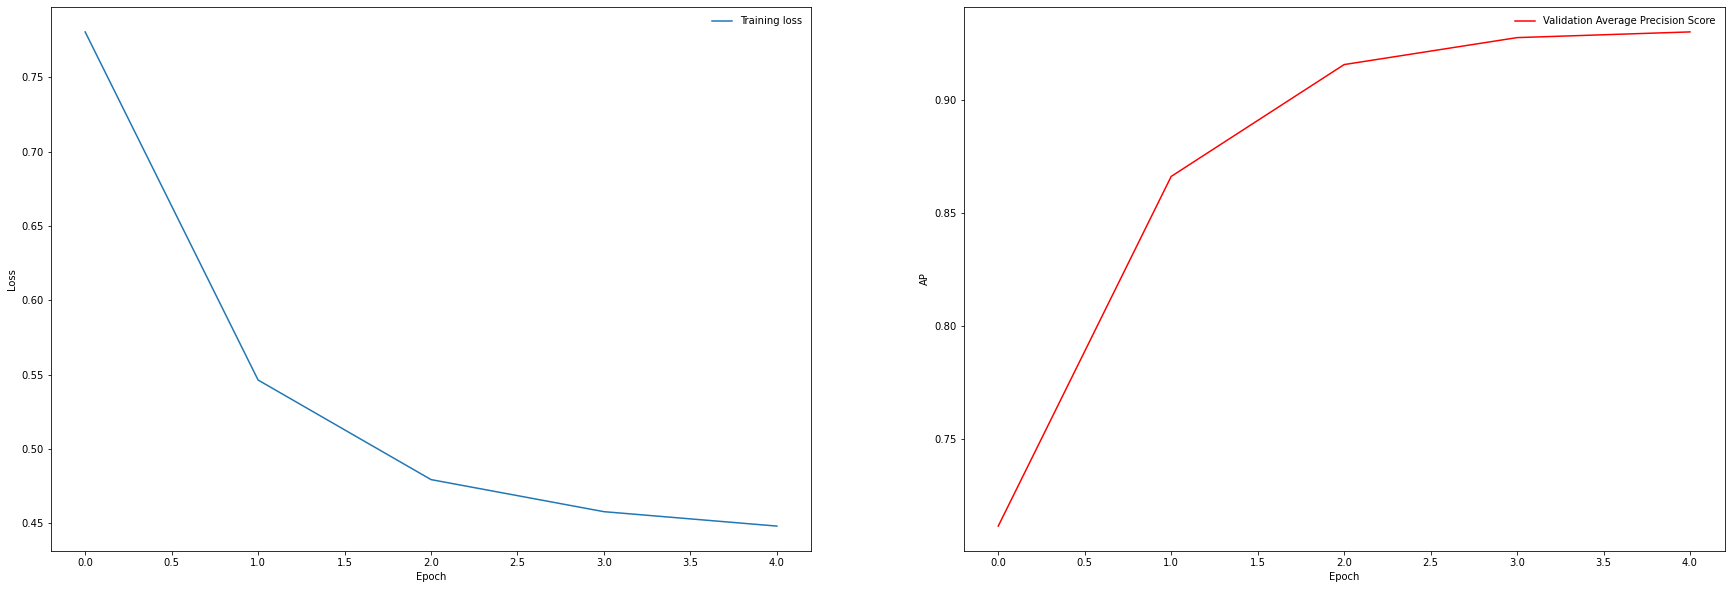

The Last Epoch's Results are:
Test ROC score: 0.9239906527586245
Test AP score: 0.93408055396711
Seed 4
Using cora dataset
Epoch: 0001 train_loss= 0.77640
val_ap= 0.74828
time= 0.05984
Epoch: 0041 train_loss= 0.51537
val_ap= 0.85720
time= 0.05386
Epoch: 0081 train_loss= 0.43830
val_ap= 0.92471
time= 0.05087
Epoch: 0121 train_loss= 0.41958
val_ap= 0.93392
time= 0.05785
Epoch: 0161 train_loss= 0.41049
val_ap= 0.93775
time= 0.05285
Optimization Finished!


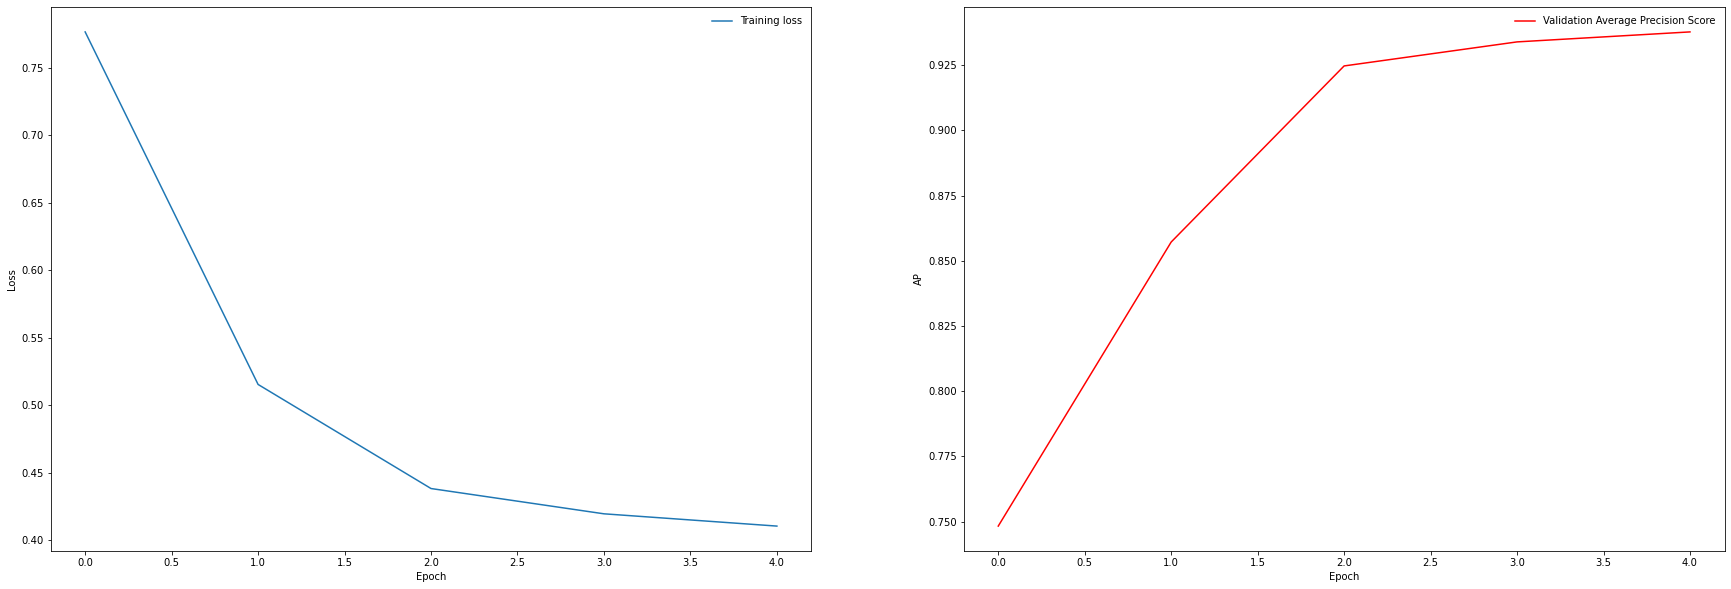

The Last Epoch's Results are:
Test ROC score: 0.9279945558440061
Test AP score: 0.9409917266506594
Seed 5
Using cora dataset
Epoch: 0001 train_loss= 0.78398
val_ap= 0.79718
time= 0.04787
Epoch: 0041 train_loss= 0.51667
val_ap= 0.87919
time= 0.05884
Epoch: 0081 train_loss= 0.44321
val_ap= 0.91214
time= 0.04987
Epoch: 0121 train_loss= 0.42380
val_ap= 0.92706
time= 0.05785
Epoch: 0161 train_loss= 0.41453
val_ap= 0.93472
time= 0.05086
Optimization Finished!


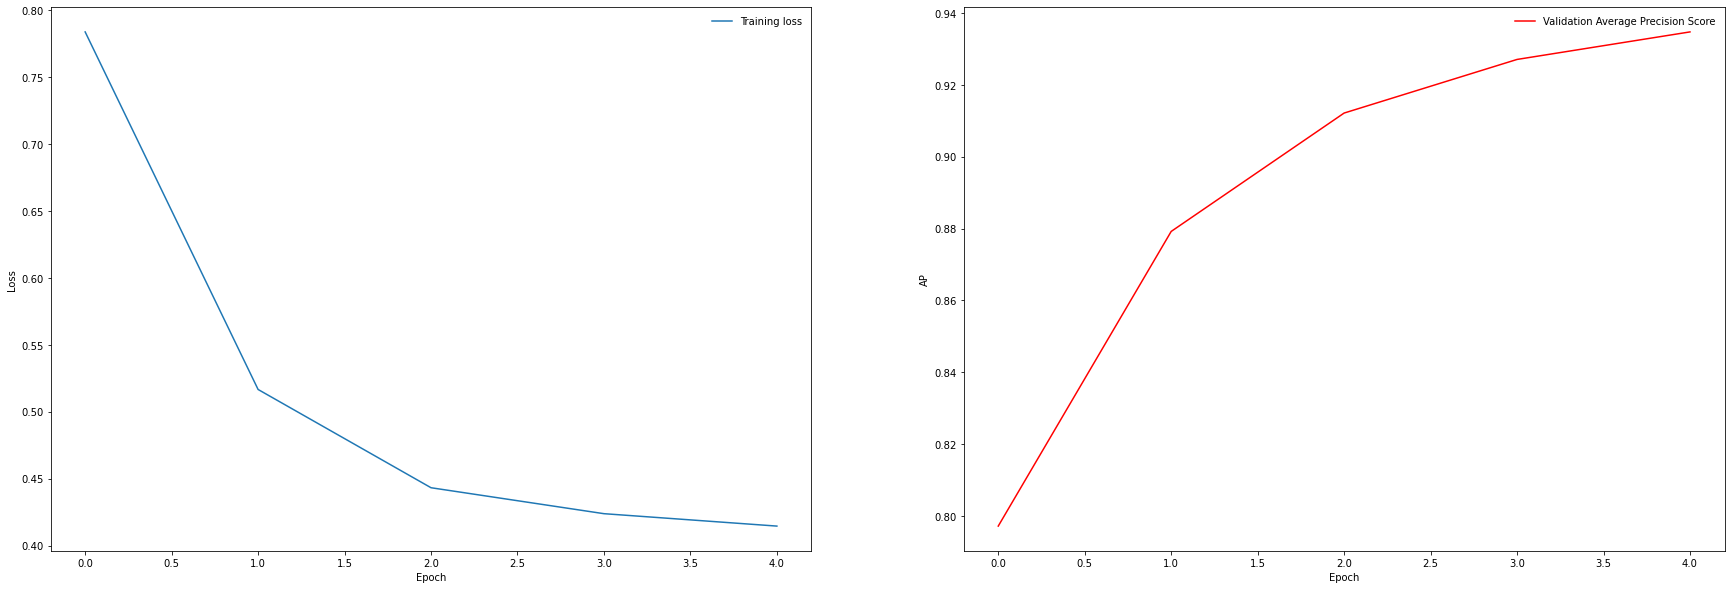

The Last Epoch's Results are:
Test ROC score: 0.9315339773664256
Test AP score: 0.9413695038345372
Seed 6
Using cora dataset
Epoch: 0001 train_loss= 0.77758
val_ap= 0.75672
time= 0.05286
Epoch: 0041 train_loss= 0.49323
val_ap= 0.87540
time= 0.06383
Epoch: 0081 train_loss= 0.44572
val_ap= 0.90284
time= 0.06383
Epoch: 0121 train_loss= 0.42793
val_ap= 0.91529
time= 0.06483
Epoch: 0161 train_loss= 0.41815
val_ap= 0.92026
time= 0.07281
Optimization Finished!


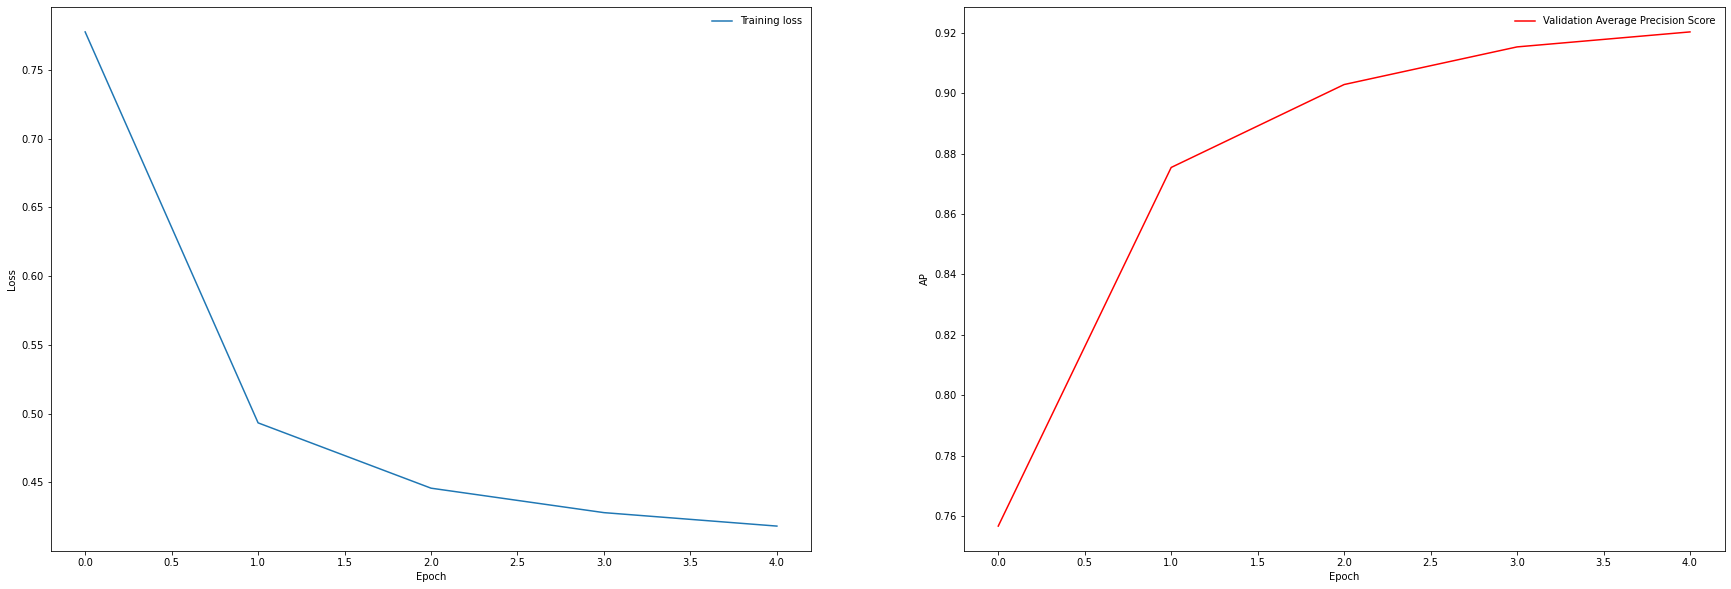

The Last Epoch's Results are:
Test ROC score: 0.926082620108091
Test AP score: 0.9360832705152662
Seed 7
Using cora dataset
Epoch: 0001 train_loss= 0.78154
val_ap= 0.76601
time= 0.07879
Epoch: 0041 train_loss= 0.52780
val_ap= 0.85515
time= 0.06483
Epoch: 0081 train_loss= 0.45830
val_ap= 0.90451
time= 0.06682
Epoch: 0121 train_loss= 0.43746
val_ap= 0.90961
time= 0.07380
Epoch: 0161 train_loss= 0.42749
val_ap= 0.91632
time= 0.08178
Optimization Finished!


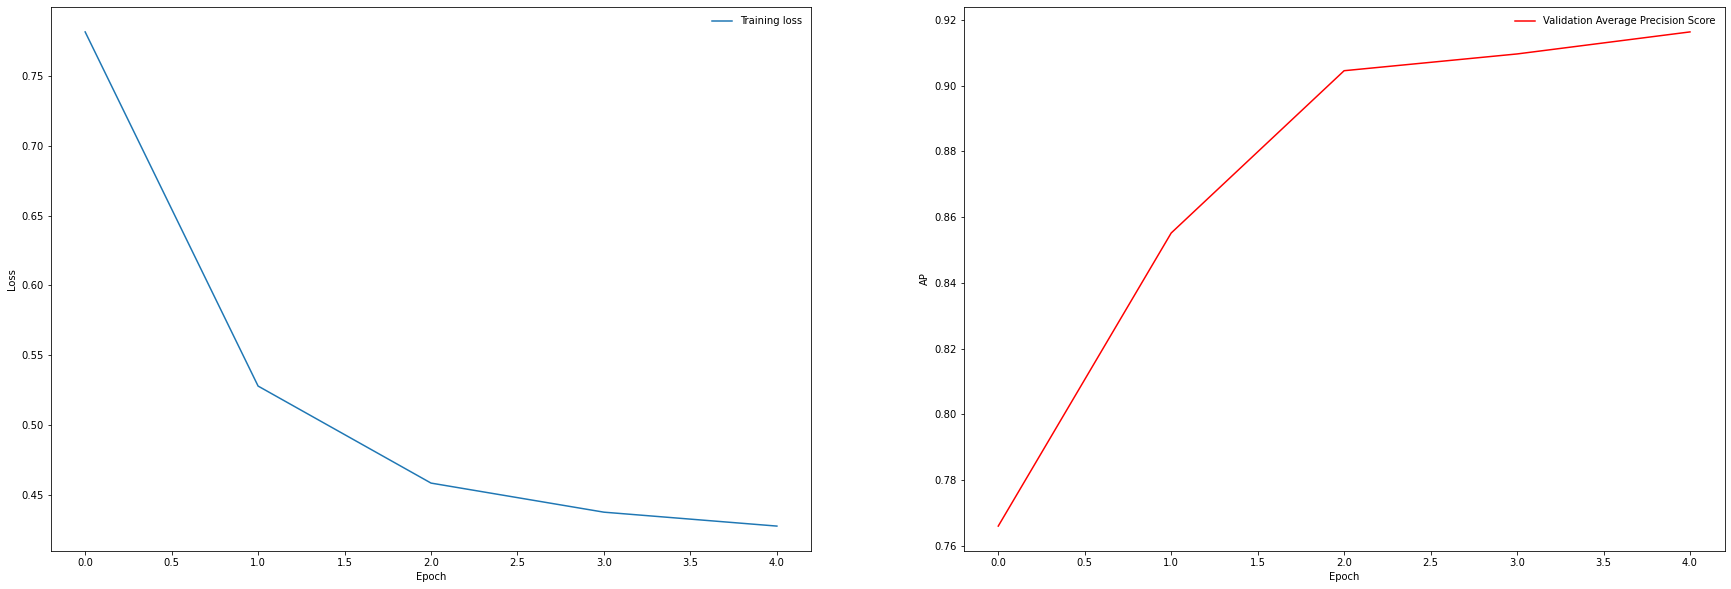

The Last Epoch's Results are:
Test ROC score: 0.9307958477508651
Test AP score: 0.939880980386731
Seed 8
Using cora dataset
Epoch: 0001 train_loss= 0.78124
val_ap= 0.75277
time= 0.06981
Epoch: 0041 train_loss= 0.53073
val_ap= 0.84968
time= 0.07979
Epoch: 0081 train_loss= 0.47346
val_ap= 0.92129
time= 0.04887
Epoch: 0121 train_loss= 0.45643
val_ap= 0.93357
time= 0.05286
Epoch: 0161 train_loss= 0.44836
val_ap= 0.93607
time= 0.06183
Optimization Finished!


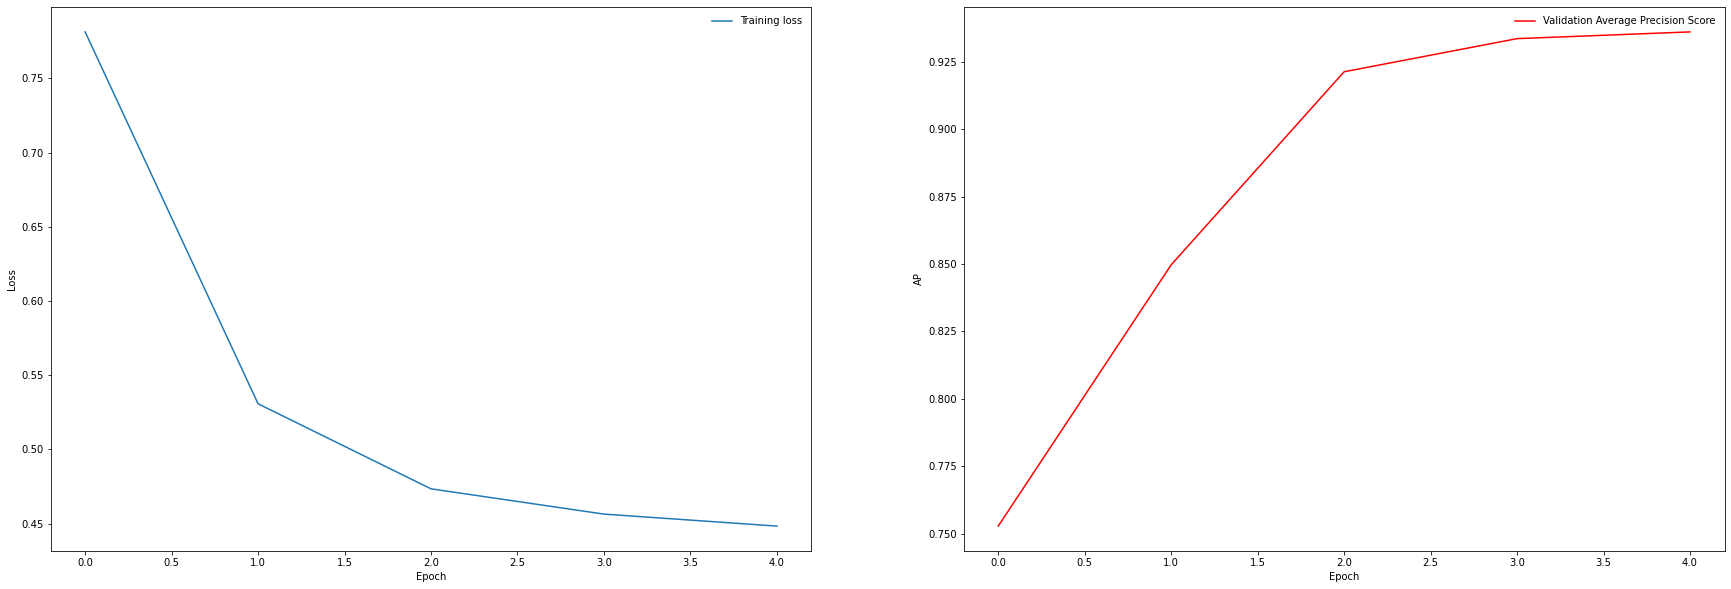

The Last Epoch's Results are:
Test ROC score: 0.9317140089799768
Test AP score: 0.9407381929408106
Seed 9
Using cora dataset
Epoch: 0001 train_loss= 0.77550
val_ap= 0.74314
time= 0.06782
Epoch: 0041 train_loss= 0.52987
val_ap= 0.88967
time= 0.07779
Epoch: 0081 train_loss= 0.46506
val_ap= 0.91327
time= 0.06582
Epoch: 0121 train_loss= 0.44846
val_ap= 0.92137
time= 0.06582
Epoch: 0161 train_loss= 0.44016
val_ap= 0.92432
time= 0.04787
Optimization Finished!


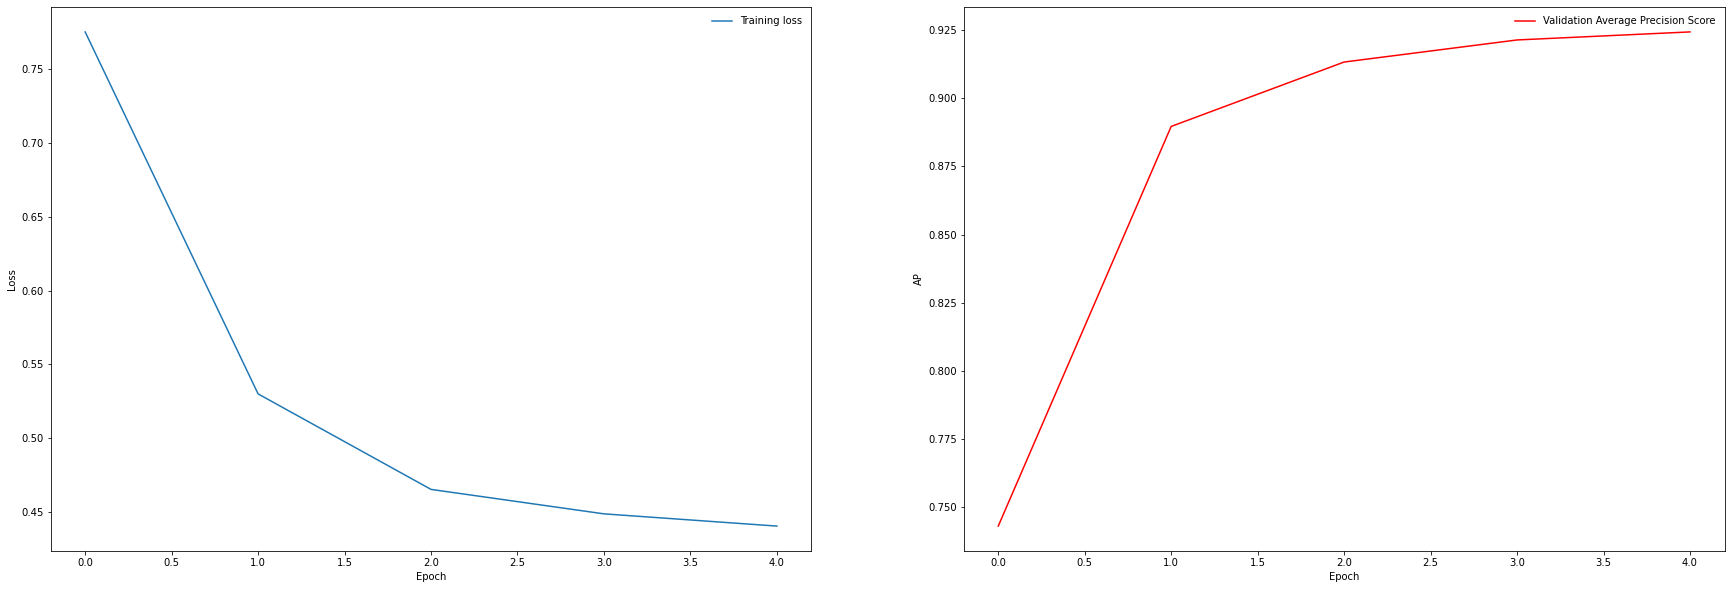

The Last Epoch's Results are:
Test ROC score: 0.925002430426783
Test AP score: 0.9354014822719563
[0.929578834043258, 0.9310730964357341, 0.9331794663142847, 0.9239906527586245, 0.9279945558440061, 0.9315339773664256, 0.926082620108091, 0.9307958477508651, 0.9317140089799768, 0.925002430426783]
mean test AUC is 0.9290945490028049  std  0.002993650314542074
[0.9373495496285346, 0.9394075000573161, 0.939186615836546, 0.93408055396711, 0.9409917266506594, 0.9413695038345372, 0.9360832705152662, 0.939880980386731, 0.9407381929408106, 0.9354014822719563]
mean test AP is  0.9384489376089468  std  0.002427441558890743


In [5]:
once = False

if __name__ == '__main__':
    if once == True:
        gae_for(args)
    
    else:
        test_roc = []
        test_ap = []
        
        # Run with 10 different random seeds
        for seed in range(10):
            print('Seed',seed)
            args.seed = seed
            torch.manual_seed(args.seed)
            roc_score, ap_score = gae_for(args)
            test_roc.append(roc_score)
            test_ap.append(ap_score)
        
        # show results by mean and std
        print(test_roc)
        print('mean test AUC is',np.mean(test_roc),' std ', np.std(test_roc))
        print(test_ap)
        print('mean test AP is ',np.mean(test_ap), ' std ', np.std(test_ap))